In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import librosa
import librosa.display 
import IPython.display as ipd


In [92]:
audio_files = glob("../input/ravdess-emotional-speech-audio/*/*.wav")

file_info = []

for i in range(len(audio_files)):
    y,sr = librosa.load(audio_files[i])
    file_info.append([y,sr])

Text(0.5, 1.0, 'Raw audio data')

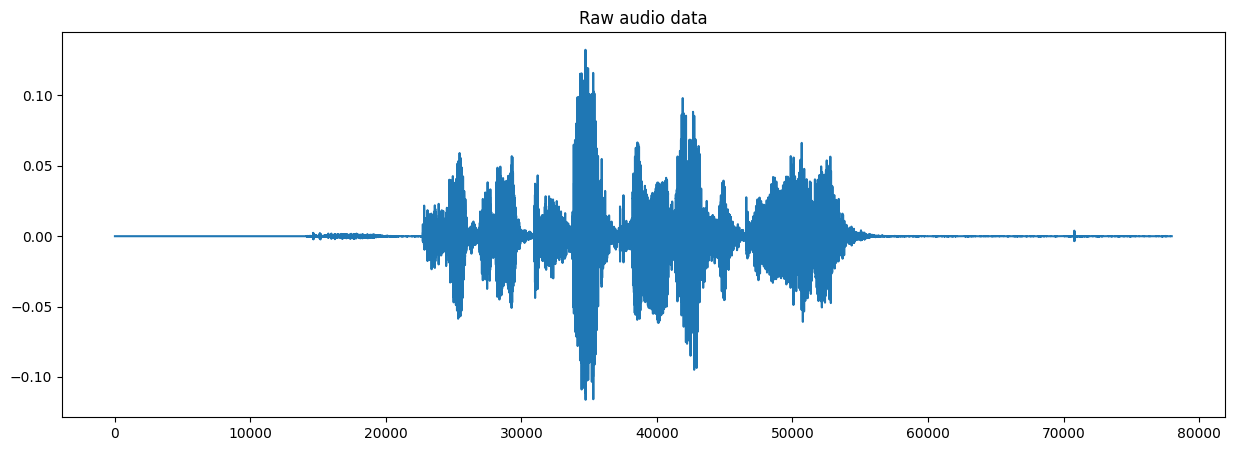

In [93]:
y,sr=librosa.load(audio_files[0])

pd.Series(y).plot(figsize=(15,5))
plt.title("Raw audio data")

In [94]:
ipd.Audio(data=y, rate=sr)

Text(0.5, 1.0, 'Raw trimmed example')

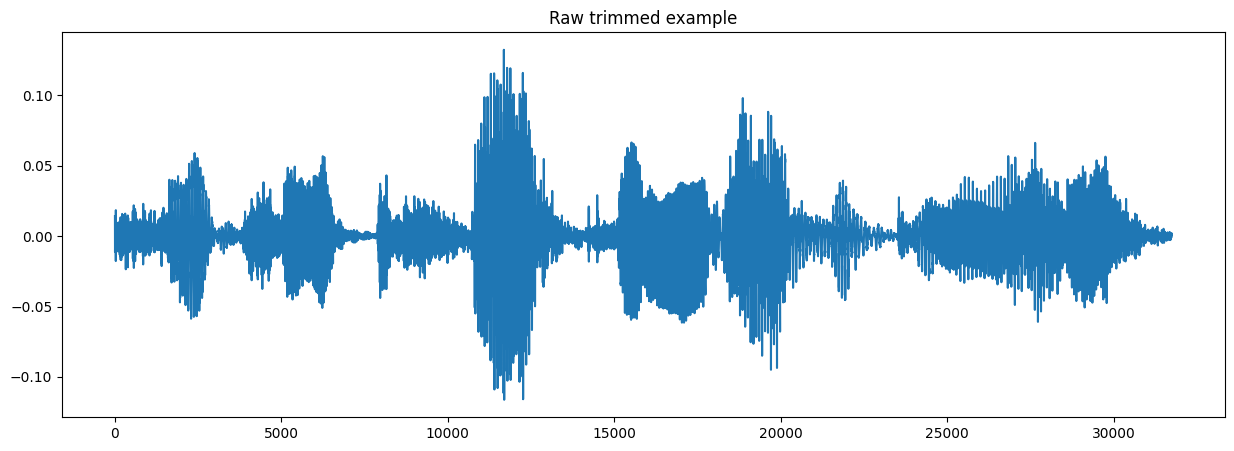

In [95]:
y_trimmed,_ = librosa.effects.trim(y,top_db=20)
pd.Series(y_trimmed).plot(figsize=(15,5))
plt.title("Raw trimmed example")

Text(0.5, 1.0, 'Raw trimmed example')

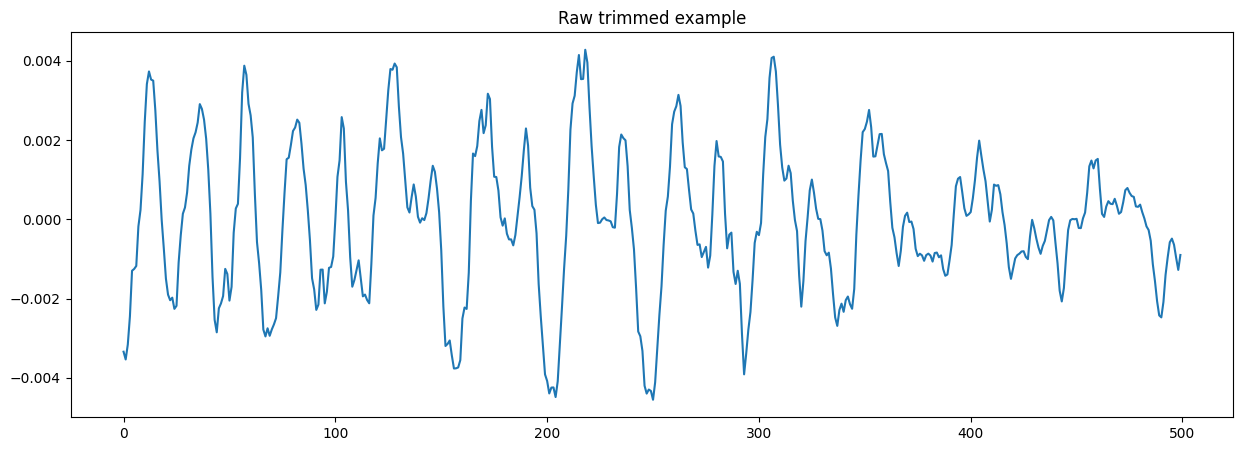

In [96]:
y_trimmed,_ = librosa.effects.trim(y[30000:30500],top_db=20)
pd.Series(y_trimmed).plot(figsize=(15,5))
plt.title("Raw trimmed example")

Spectogram looking into frequencies

In [97]:
D = librosa.stft(y) #short time fourier transform

sound_db = librosa.amplitude_to_db(np.abs(D),ref=np.max)

Text(0.5, 1.0, 'Spectogram')

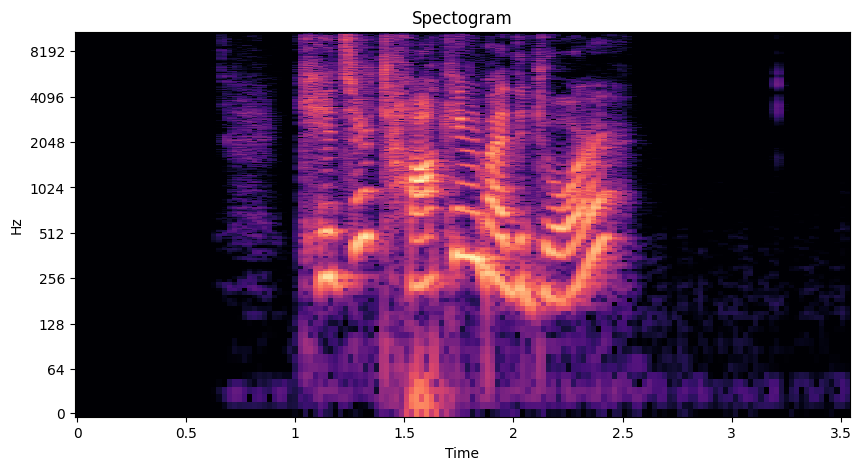

In [98]:
fig,ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(sound_db,x_axis='time',y_axis='log',ax=ax)
ax.set_title("Spectogram")

Text(0.5, 1.0, 'Spectogram')

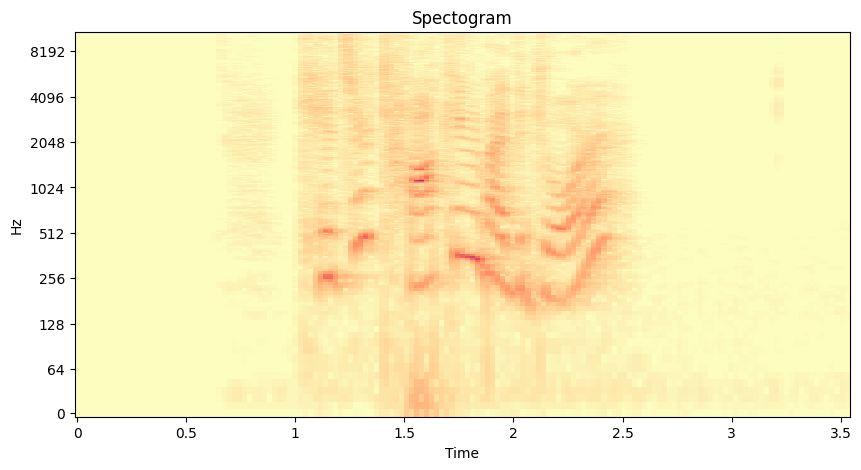

In [99]:
S_db_mel = librosa.amplitude_to_db(sound_db,ref=np.max)

fig,ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_mel,x_axis='time',y_axis='log',ax=ax)
ax.set_title("Spectogram")

In [100]:
def remove_silence_energy(y, threshold=0.002):
    # Calculate energy in each frame
    energy = np.sum(np.abs(librosa.stft(y)), axis=0)

    # Identify frames with energy above the threshold
    non_silent_frames = energy > threshold

    # Apply silence removal
    y_silence_removed = y[librosa.frames_to_samples(non_silent_frames)]

    return y_silence_removed

In [101]:
def zero_crossings(x):
    zero_crossings=[]
    silence_removed=[]
    silence_removed=np.array(silence_removed)
    for i  in range(1,len(x)):
        # detecting zero crossing
        if(x[i-1]<=0 and x[i]>0):
            zero_crossings.append(1)
        else:
            zero_crossings.append(0)
    for i in range(len(zero_crossings)-3):
        zeros=np.sum(zero_crossings[4*i:4*(i+1)])
        #print(zeros)
        zeros=4-zeros
        if(zeros>2):
            silence_removed=np.concatenate((silence_removed,np.array(x[4*i:4*(i+1)])))
    print("Before Silence Removal : ",len(x),"\nAfter Silence Removal : ",len(silence_removed))
    return silence_removed

In [102]:
silence_removed=zero_crossings(y)

Before Silence Removal :  77988 
After Silence Removal :  68856


In [103]:
ipd.Audio(data=y, rate=sr)

In [104]:
ipd.Audio(data=silence_removed, rate=sr)

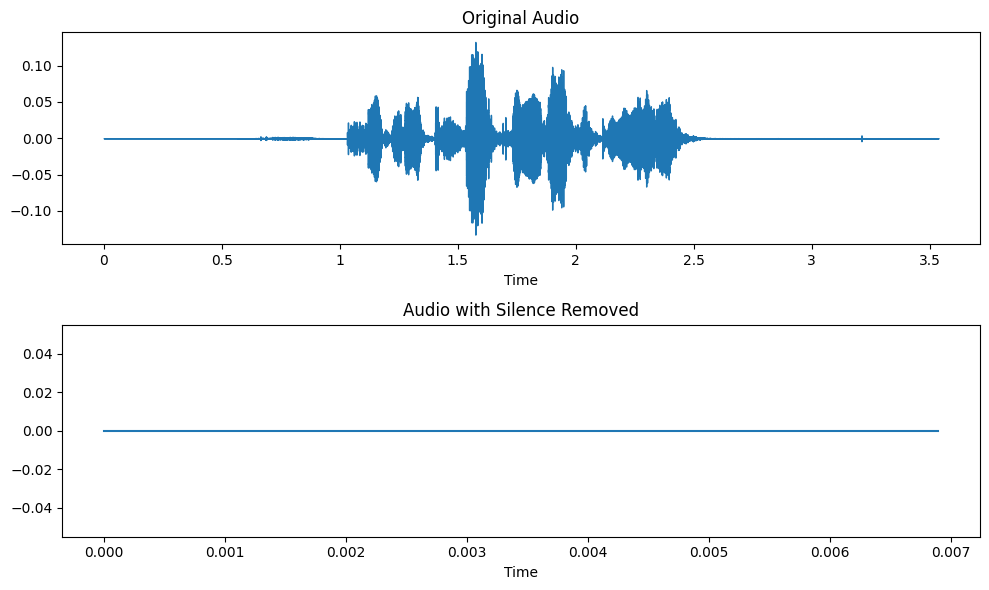

In [105]:
y_silence_removed = remove_silence_energy(y)

# Plot the original and processed signals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Original Audio')

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_silence_removed, sr=sr)
plt.title('Audio with Silence Removed')

plt.tight_layout()
plt.show()

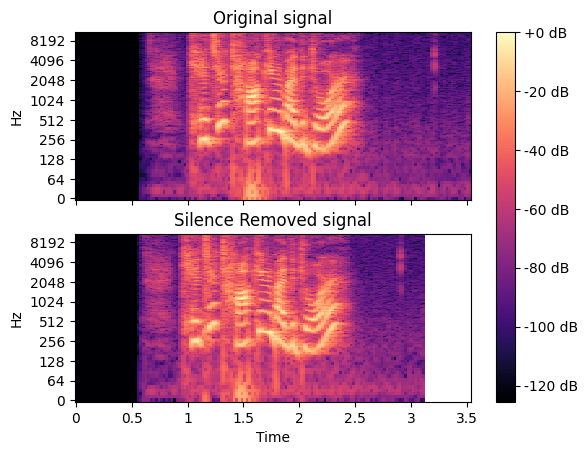

In [106]:

# Assuming 'y' is the original audio signal and 'silence_removed' is the signal with silence removed

# Convert amplitude to decibels and compute the spectrogram for the original signal
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max, top_db=None)

# Convert amplitude to decibels and compute the spectrogram for the signal with silence removed
S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(silence_removed)), ref=np.max, top_db=None)

# Create subplots for the original signal and the signal with silence removed
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)

# Display the spectrogram of the original signal
librosa.display.specshow(S_orig, y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Original signal')
ax[0].label_outer()

# Display the spectrogram of the signal with silence removed
img = librosa.display.specshow(S_preemph, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Silence Removed signal')

# Add a colorbar to both subplots
fig.colorbar(img, ax=ax, format="%+2.f dB")

# Show the plot
plt.show()


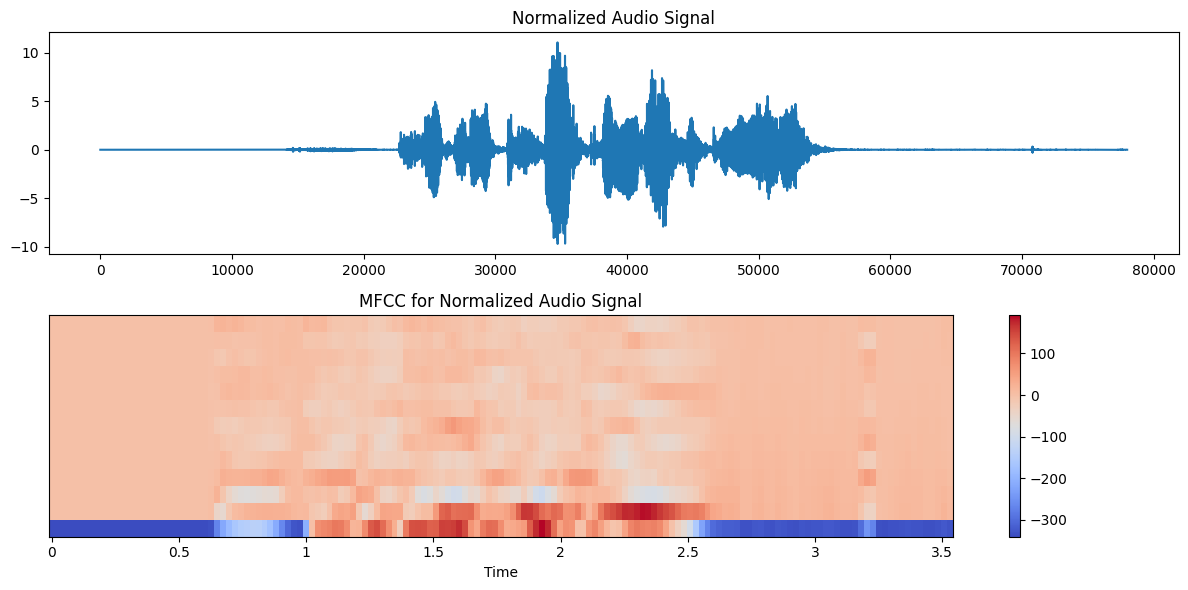

In [108]:
from sklearn.preprocessing import StandardScaler

# Assuming 'y' is the original audio signal

# Apply z-score normalization to the original audio signal
scaler = StandardScaler()
y_normalized = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Extract MFCC features for the normalized signal
mfcc_normalized = librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=13)

# Visualize the normalized MFCC features
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(y_normalized)
plt.title('Normalized Audio Signal')

plt.subplot(2, 1, 2)
librosa.display.specshow(mfcc_normalized, x_axis='time')
plt.colorbar()
plt.title('MFCC for Normalized Audio Signal')

plt.tight_layout()
plt.show()


In [140]:
def preprocessing(file):
    X,sample_rate = librosa.load(file)
    # zero crossing
    #silence_removed=zero_crossing(X)
    # Pre emphasis
    y_filt = librosa.effects.preemphasis(X)
    # normalization
    #x_norm=y_filt/max(y_filt)
    return y_filt,sample_rate

In [110]:
emotions_all={
    '01' : 'neutral', 
    '02' : 'calm' ,
    '03' : 'happy' ,
    '04' : 'sad' ,
    '05' : 'angry', 
    '06' : 'fearful' ,
    '07' : 'disgust', 
    '08' : 'surprised'
}

In [141]:
def feature_extraction(X,sample_rate):
    result = np.array([])

    # chroma stft: Compute a chromagram from a waveform or power spectrum
    stft = np.abs(librosa.stft(X))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))
    
    # mfcc: Mel-frequency cepstral coefficients
    mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
    
    # melspectogram: Compute a mel-scaled spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
    result=np.hstack((result, mel))
    
    return result

In [143]:
x,y=[],[]
# Considered the following emotions
emotions=['happy','sad','angry','fearful','disgust']

from IPython.display import clear_output
e = set()

for file in audio_files:
        clear_output(wait=True)
        file_name = file.split('/')[-1]
        emotion=emotions_all[file_name.split("-")[2]]
        if emotion not in emotions:
            continue
        e.add(file.split('/')[-2])
        # preprocessing audio data
        pre_speech=preprocessing(file)
        # feature extraction from audio
        feature=feature_extraction(pre_speech[0],pre_speech[1])
        print(e)
        x.append(feature)
        y.append(emotion)

{'Actor_21', 'Actor_14', 'Actor_17', 'Actor_16', 'Actor_07', 'Actor_18', 'Actor_09', 'Actor_10', 'Actor_04', 'Actor_08', 'Actor_05', 'Actor_11', 'Actor_12', 'Actor_01', 'Actor_19', 'Actor_24', 'Actor_13', 'Actor_02', 'Actor_20', 'Actor_23', 'Actor_03', 'Actor_06', 'Actor_15', 'Actor_22'}


In [144]:
print(e)
print(len(y))

{'Actor_21', 'Actor_14', 'Actor_17', 'Actor_16', 'Actor_07', 'Actor_18', 'Actor_09', 'Actor_10', 'Actor_04', 'Actor_08', 'Actor_05', 'Actor_11', 'Actor_12', 'Actor_01', 'Actor_19', 'Actor_24', 'Actor_13', 'Actor_02', 'Actor_20', 'Actor_23', 'Actor_03', 'Actor_06', 'Actor_15', 'Actor_22'}
960


In [145]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [146]:
from sklearn.preprocessing import MinMaxScaler
scaler  =  MinMaxScaler()
x = scaler.fit_transform(x)

In [147]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=4,shuffle=True,stratify=y)

In [204]:
# XGBClassifier: Boosting algorithm based on gradient boosted decision trees algorithm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model_xg=XGBClassifier()
#Training
model_xg.fit(x_train,y_train)
#Prediction
y_pred1=model_xg.predict(x_test)
print(accuracy_score(y_test,y_pred1))

0.6666666666666666


In [205]:
# LGBMClassifier: Light gradient boosting
import lightgbm as lgb
#from lightgbm import LightGBMClassifier
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')
y_pred2=model.predict(x_test)
print(accuracy_score(y_test,y_pred2))

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's multi_logloss: 0.302931	valid_0's multi_logloss: 1.06295
[40]	training's multi_logloss: 0.0643087	valid_0's multi_logloss: 0.976731
[60]	training's multi_logloss: 0.0140864	valid_0's multi_logloss: 0.991816
[80]	training's multi_logloss: 0.00307539	valid_0's multi_logloss: 1.02906
[100]	training's multi_logloss: 0.000672498	valid_0's multi_logloss: 1.10211
0.6875


In [218]:
tests,sr=librosa.load('../input/ravdess-emotional-speech-audio/Actor_01/03-01-03-02-02-02-01.wav')

ipd.Audio(data=tests, rate=sr)

In [223]:
emotion=emotions_all['03-01-03-02-02-02-01'.split("-")[2]]
emotion

'happy'

In [224]:
y,sr=librosa.load('../input/ravdess-emotional-speech-audio/Actor_01/03-01-03-02-02-02-01.wav')
ipd.Audio(data=y,rate=sr)

In [221]:
x=[]
y=[]
pre_speech=preprocessing('../input/ravdess-emotional-speech-audio/Actor_01/03-01-03-02-02-02-01.wav')
feature=feature_extraction(pre_speech[0],pre_speech[1])
x.append(feature)
y.append(emotion)

In [222]:
pred=model_xg.predict(x)
label_encoder.inverse_transform(pred)

array(['happy'], dtype='<U7')